The objective of this notebook is to test if rewiring some edges after the network generation can better fit the degree distribution to the experimental data.

# Packages

In [3]:
# Editing mode
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.stats import pearsonr
import GRNgene as gg
import cma
import numpy as np
import pickle as pkl
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
random.seed(1)

In [47]:
def power_law(x, a, b):
    return a * np.power(x, b)

def plot_degrees(
    G: nx.DiGraph,
    plot_fit: bool = False
):
    """
    Plot the total, in- and out- degree distribution of a network and optionally fit a power law.

    Parameters
    ----------
    G : nx.DiGraph
        Directed graph representing the gene regulatory network.
    
    plot_fit : bool, optional (default=False)
        If True, fit and overlay a power-law curve on the degree distribution plot.
        
    Returns
    -------
    None
        Displays the plots and prints the fitted power law parameters if `plot_fit` is True.
    """
    N = G.number_of_nodes()
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    degree_counts = np.unique(degree_sequence, return_counts=True)
    degrees = degree_counts[0]
    counts = degree_counts[1]
    probabilities = counts / N
               
    in_degree_sequence = sorted((d for n, d in G.in_degree()), reverse=True)
    in_dmax = max(in_degree_sequence)
    in_degree_counts = np.unique(in_degree_sequence, return_counts=True)
    in_degrees = in_degree_counts[0]
    in_counts = in_degree_counts[1]
    in_probabilities = in_counts / N

    out_degree_sequence = sorted((d for n, d in G.out_degree()), reverse=True)
    out_dmax = max(out_degree_sequence)
    out_degree_counts = np.unique(out_degree_sequence, return_counts=True)
    out_degrees = out_degree_counts[0]
    out_counts = out_degree_counts[1]
    out_probabilities = out_counts / N
    
    fig = plt.figure("Degree distribution", figsize=(8, 8))
    axgrid = fig.add_gridspec(3, 2)

    # Total degree
    ax0 = fig.add_subplot(axgrid[0, 0])
    mask = degrees > 0
    ax0.scatter(np.log(degrees[mask]), np.log(probabilities[mask]), marker="o", color="b")
    ax0.set_title("log-log Degree Distribution")
    ax0.set_ylabel("log P(k)")
    ax0.set_xlabel("log Degree k")
    
    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, degrees[degrees > 0], probabilities[degrees > 0])
        ax0.plot(
            np.log(degrees[degrees > 0]),
            np.log(power_law(degrees[degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax0.legend()
    
    # Degree histogram
    ax1 = fig.add_subplot(axgrid[0, 1])
    ax1.bar(degrees, counts)
    ax1.set_title("Degree Histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Number of Nodes")

    # In-degree
    ax2 = fig.add_subplot(axgrid[1, 0])
    in_mask = in_degrees > 0
    ax2.scatter(np.log(in_degrees[in_mask]), np.log(in_probabilities[in_mask]), marker="o", color="b")
    ax2.set_title("Log-Log In-Degree Distribution")
    ax2.set_ylabel("Log P(k)")
    ax2.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, in_degrees[in_degrees > 0], in_probabilities[in_degrees > 0])
        ax2.plot(
            np.log(in_degrees[in_degrees > 0]),
            np.log(power_law(in_degrees[in_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax2.legend()

    # Degree histogram
    ax2 = fig.add_subplot(axgrid[1, 1])
    ax2.bar(in_degrees, in_counts)
    ax2.set_title("Degree Histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("Number of Nodes")
    
    # Out-degree
    ax3 = fig.add_subplot(axgrid[2, 0])
    out_mask = out_degrees > 0
    ax3.scatter(np.log(out_degrees[out_mask]), np.log(out_probabilities[out_mask]), marker="o", color="b")
    ax3.set_title("Log-Log Out-Degree Distribution")
    ax3.set_ylabel("Log P(k)")
    ax3.set_xlabel("Log Degree k")

    # Fit and plot power law
    params = None
    if plot_fit:
        params, _ = curve_fit(power_law, out_degrees[out_degrees > 0], out_probabilities[out_degrees > 0])
        ax3.plot(
            np.log(out_degrees[out_degrees > 0]),
            np.log(power_law(out_degrees[out_degrees > 0], *params)),
            'r--',
            label='Power law fit'
        )
        ax3.legend()

    # Degree histogram
    ax4 = fig.add_subplot(axgrid[2, 1])
    ax4.bar(out_degrees, out_counts)
    ax4.set_title("Out-Degree Histogram")
    ax4.set_xlabel("Degree")
    ax4.set_ylabel("Number of Nodes")

    fig.tight_layout()
    plt.show()

    if params is not None:
        print(f"Fitted power law parameters: a = {params[0]:.2f}, b = {params[1]:.2f}")

# E.Coli network property

In [5]:
filepath = '../../data/gnw/Ecoli-full.tsv'
adj_mx = gg.adj_mx_gnw_goldstandard(filepath)
ecoli_grn = nx.from_numpy_array(adj_mx, create_using=nx.DiGraph())

# Get the largest weakly connected component
largest_weakly_cc = max(nx.weakly_connected_components(ecoli_grn), key=len)

# Create the subgraph
ecoli_largest = ecoli_grn.subgraph(largest_weakly_cc).copy()

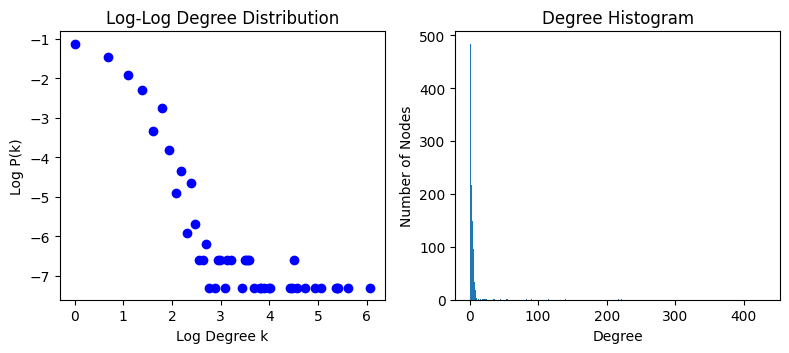

{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

In [7]:
gg.plot_grn_degree(ecoli_largest, plot_network=False)
largest_gnw_properties = gg.network_properties(ecoli_largest)
largest_gnw_properties

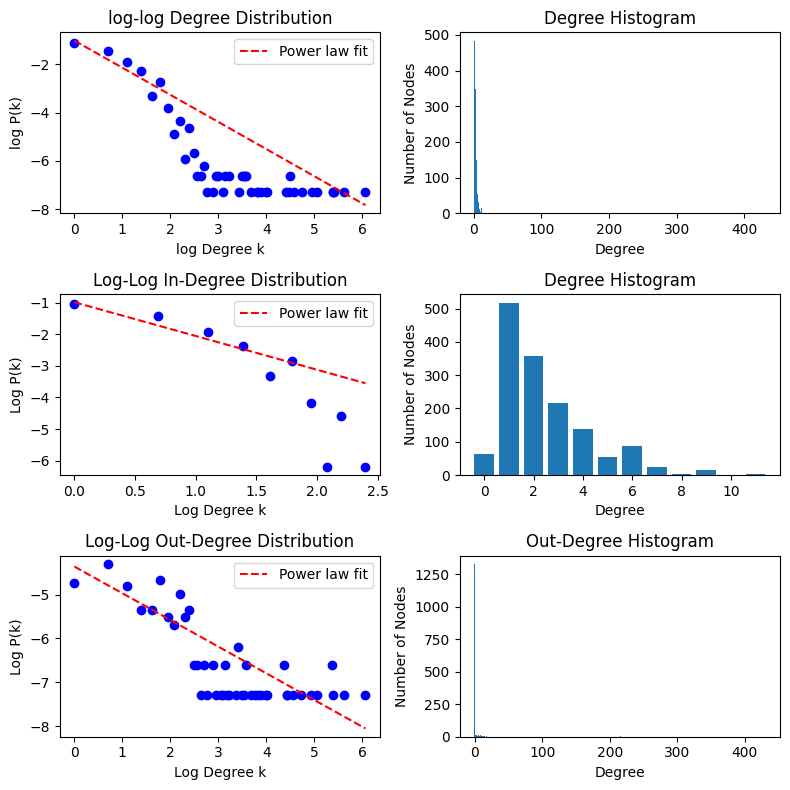

Fitted power law parameters: a = 0.01, b = -0.61


{'avg_clustering': 0.1393885626587736,
 'avg_degree': 4.844955991875423,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  18,  19,  20,  22,  23,  25,  31,  33,  34,  35,
         36,  40,  45,  46,  49,  54,  55,  83,  87,  90,  97, 115, 140,
        158, 217, 218, 222, 278, 431]),
 'density': 0.0016412452547003467,
 'degree_proba': array([0.32701422, 0.23561273, 0.14691943, 0.10088016, 0.03588355,
        0.06431957, 0.02234259, 0.00744753, 0.01286391, 0.00270819,
        0.00947867, 0.00338524, 0.0013541 , 0.0013541 , 0.00203114,
        0.00067705, 0.00067705, 0.0013541 , 0.0013541 , 0.00067705,
        0.0013541 , 0.0013541 , 0.00067705, 0.0013541 , 0.0013541 ,
        0.0013541 , 0.0013541 , 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.0013541 , 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.0006

In [50]:
plot_degrees(ecoli_largest, plot_fit=True)
largest_gnw_properties

# Generate synthetic graph

The parameters used comes from an optimization with CMA-ES to match some E.coli network properties.

In [15]:
tau1, tau2, mu, hub_bias, min_community, max_community = [2.11905595, 1.20991633, 0.50243064, 3.14983374, 5.10054852, 500.4941408]

LFR_params = dict(
n=ecoli_largest.number_of_nodes(),
tau1=tau1,
tau2=tau2,
mu=mu,
seed=None,
average_degree=4.8,
min_community=min_community,
max_community=max_community,
hub_bias = hub_bias
)

G_lfr = gg.LFRAlgorithm(max_retries=20,**LFR_params)

G_lfr_directed = gg.adjacenteDiMatriceStaredFromGraph(
    G_lfr,
    autoRG=0.0,   # self-loop probability
    duoRG=0.005    # bidirectional edge probability
)


Generation failed on attempt 1, retrying...


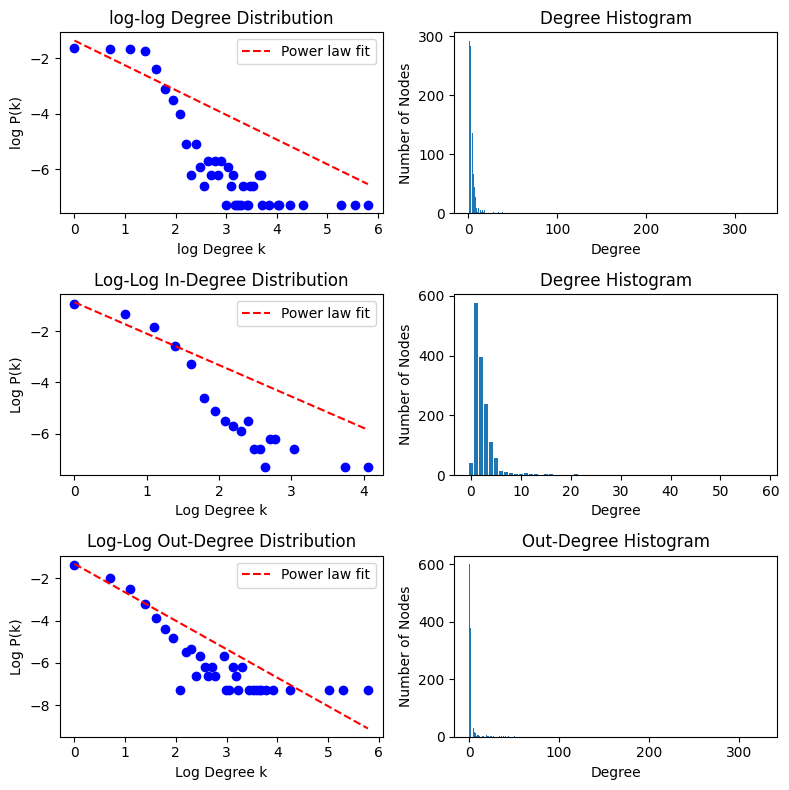

Fitted power law parameters: a = 0.27, b = -1.34


{'avg_clustering': 0.033180474700093804,
 'avg_degree': 4.682464454976303,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  30,  31,  32,  34,  38,  40,  41,  47,  56,  57,  71,  91,
        193, 256, 330]),
 'density': 0.001586200696130184,
 'degree_proba': array([0.19769804, 0.19228165, 0.18957346, 0.17806364, 0.09207854,
        0.04468517, 0.02979012, 0.0182803 , 0.00609343, 0.00203114,
        0.00609343, 0.00270819, 0.0013541 , 0.00338524, 0.00203114,
        0.00338524, 0.00203114, 0.00338524, 0.00067705, 0.00270819,
        0.0013541 , 0.00203114, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.0013541 , 0.00067705, 0.00067705, 0.0013541 ,
        0.0013541 , 0.00203114, 0.00203114, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705]),
 'modularity_value': 0.4591900465013098,
 

In [49]:
plot_degrees(G_lfr_directed[0], plot_fit=True)
synth_grn_properties = gg.network_properties(G_lfr_directed[0])
synth_grn_properties

# Rewiring

## Removing edges

In [33]:
def enforce_descending_degrees(G: nx.DiGraph, max_degree=4, verbose=False):
    """
    Modify G in-place by removing edges from nodes of total degree 2–4
    until the degree frequencies for degrees 1 to 4 are strictly descending.
    """
    iteration = 0
    while True:
        degrees = dict(G.degree())
        deg_counts = Counter(deg for deg in degrees.values() if 1 <= deg <= max_degree)
        freqs = [deg_counts.get(d, 0) for d in range(1, max_degree + 1)]

        if verbose:
            print(f"[Iteration {iteration}] Degree frequencies (1-4): {freqs}")

        # Check if strictly descending
        descending_ok = all(freqs[i] > freqs[i+1] for i in range(len(freqs) - 1))
        if descending_ok:
            if verbose:
                print("Distribution is descending.")
            break

        # Find the first violation (deg_k+1 >= deg_k)
        for k in range(1, max_degree):
            if freqs[k] >= freqs[k - 1]:
                violating_deg = k + 1
                candidates = [n for n, d in degrees.items() if d == violating_deg]
                random.shuffle(candidates)

                for node in candidates:
                    in_edges = list(G.in_edges(node))
                    out_edges = list(G.out_edges(node))
                    all_edges = in_edges + out_edges
                    if not all_edges:
                        continue
                    edge = random.choice(all_edges)
                    G.remove_edge(*edge)
                    if verbose:
                        print(f"Removed edge {edge} from node {node} (deg={violating_deg})")
                    break  # Exit after one removal
                break  # Restart outer loop
        iteration += 1

    return G


In [42]:
rewired_G = enforce_descending_degrees(G_lfr_directed[0], verbose=False)

In [55]:
import networkx as nx
import numpy as np
import random

def connect_components_by_hubs(G: nx.DiGraph, hub_bias=3.0, mode='auto', verbose=False):
    """
    Connect disconnected weakly connected components in a directed graph
    by adding edges between hubs (high-degree nodes).

    Parameters
    ----------
    G : nx.DiGraph
        The directed graph (modified in-place).
    hub_bias : float
        Bias factor (> 1 favors high-degree nodes).
    mode : str
        'auto' (default): randomly pick direction
        'out' : source -> target
        'in'  : target -> source
    verbose : bool
        Print progress information.
    """
    W = G.to_undirected()
    components = list(nx.connected_components(W))
    if len(components) <= 1:
        if verbose:
            print("Graph is already weakly connected.")
        return G

    if verbose:
        print(f"Connecting {len(components)} components...")

    # Sort components by size
    components = sorted(components, key=len, reverse=True)

    for i in range(len(components) - 1):
        compA = components[i]
        compB = components[i + 1]

        # Degree dictionary (total degree)
        degA = {n: G.degree(n) for n in compA}
        degB = {n: G.degree(n) for n in compB}

        # Compute hub-biased probabilities
        nodesA, weightsA = zip(*[(n, (d + 1e-3) ** hub_bias) for n, d in degA.items()])
        nodesB, weightsB = zip(*[(n, (d + 1e-3) ** hub_bias) for n, d in degB.items()])
        probA = np.array(weightsA) / np.sum(weightsA)
        probB = np.array(weightsB) / np.sum(weightsB)

        u = np.random.choice(nodesA, p=probA)
        v = np.random.choice(nodesB, p=probB)

        # Determine direction
        if mode == 'auto':
            if random.random() < 0.5:
                G.add_edge(u, v)
            else:
                G.add_edge(v, u)
        elif mode == 'out':
            G.add_edge(u, v)
        elif mode == 'in':
            G.add_edge(v, u)
        else:
            raise ValueError("mode must be 'auto', 'in', or 'out'.")

    return G


In [57]:
connect_components_by_hubs(rewired_G, hub_bias=3.0, mode='out', verbose=True)

# Confirm weak connectivity
print(nx.is_weakly_connected(G))


Graph is already weakly connected.
True


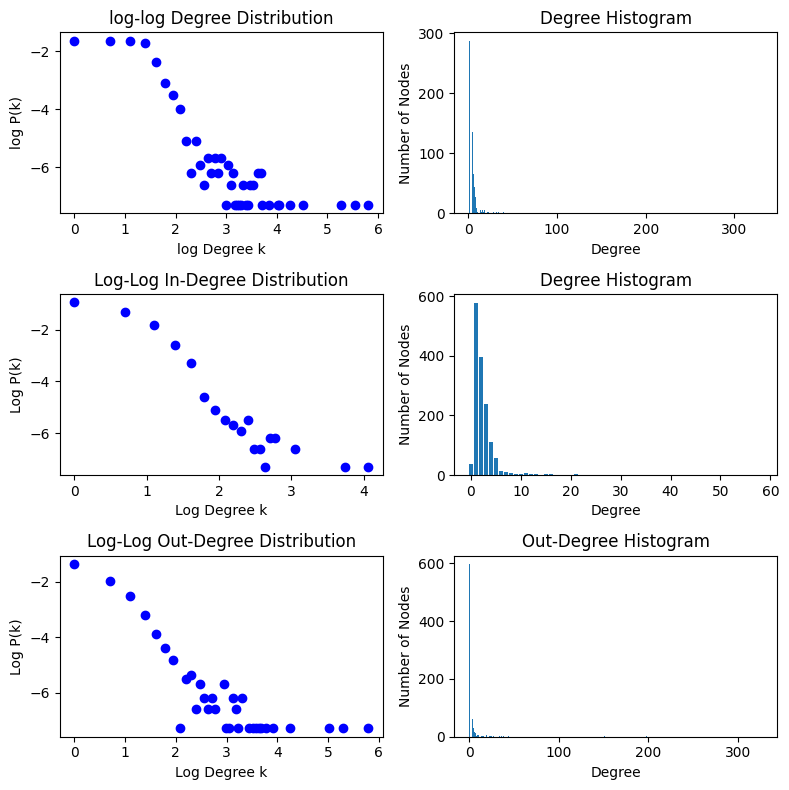

{'avg_clustering': 0.03318046844451334,
 'avg_degree': 4.687880839539607,
 'degrees': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  30,  31,  32,  34,  38,  40,  41,  47,  56,  57,  71,  91,
        193, 256, 331]),
 'density': 0.0015880355147491895,
 'degree_proba': array([0.1943128 , 0.1943128 , 0.19092756, 0.17806364, 0.09207854,
        0.04468517, 0.02979012, 0.0182803 , 0.00609343, 0.00203114,
        0.00609343, 0.00270819, 0.0013541 , 0.00338524, 0.00203114,
        0.00338524, 0.00203114, 0.00338524, 0.00067705, 0.00270819,
        0.0013541 , 0.00203114, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.0013541 , 0.00067705, 0.00067705, 0.0013541 ,
        0.0013541 , 0.00203114, 0.00203114, 0.00067705, 0.00067705,
        0.00067705, 0.00067705, 0.00067705, 0.00067705, 0.00067705,
        0.00067705, 0.00067705]),
 'modularity_value': 0.45843189639389487,


In [61]:
plot_degrees(rewired_G, plot_fit=False)
rewired_grn_properties = gg.network_properties(rewired_G)
rewired_grn_properties

# Comparison

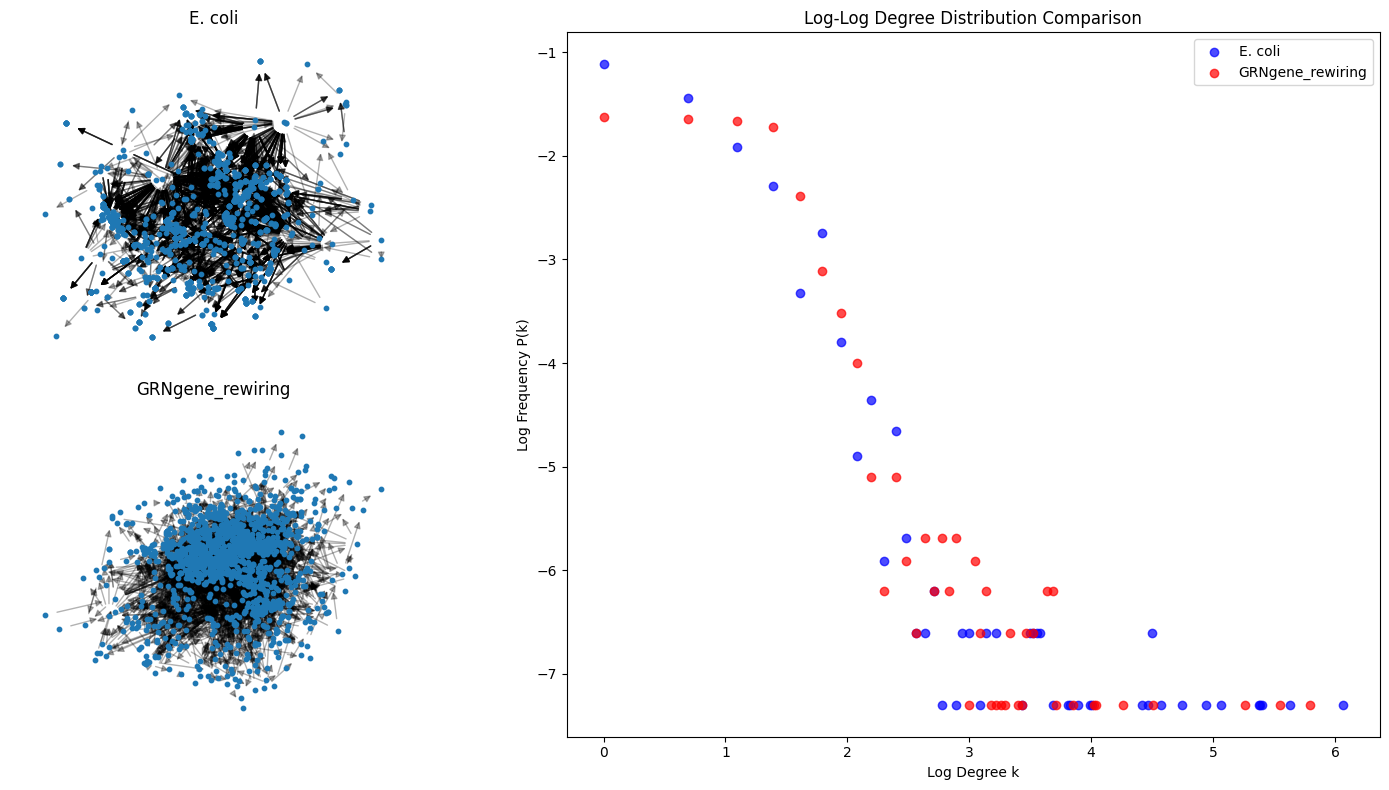

In [51]:
gg.plot_degree_network(ecoli_largest,rewired_G,'E. coli', 'GRNgene_rewiring')

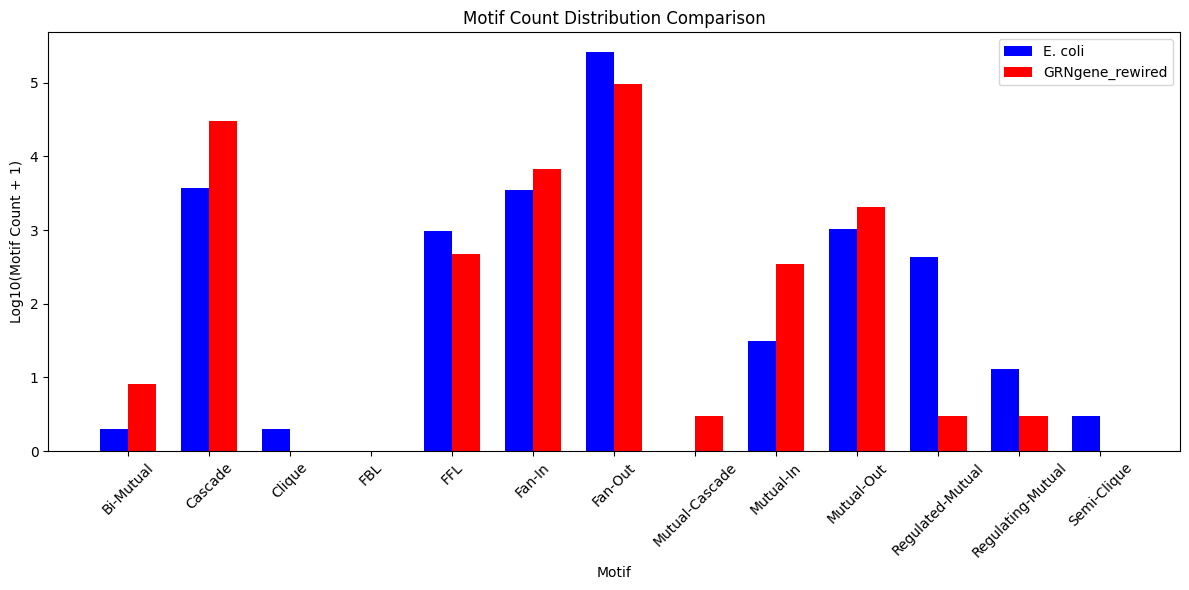

In [62]:
gg.compare_motif_dist(ecoli_largest, rewired_G, "E. coli", "GRNgene_rewired")#, save_filename='motif_distribution.eps')

In [60]:
pearson_corr, pearson_p, spearman_corr, spearman_p = gg.correlation_metrics(ecoli_largest,  rewired_G)

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.5f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.5f})")

Pearson correlation: 0.869 (p=0.00011)
Spearman correlation: 0.958 (p=0.00000)
